In [1]:
import pandas as pd  
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# Data Source : https://fred.stlouisfed.org/series/MRTSSM448USN

In [3]:
df = pd.read_csv('../Data/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [6]:
df.columns = ['Sales']

In [7]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

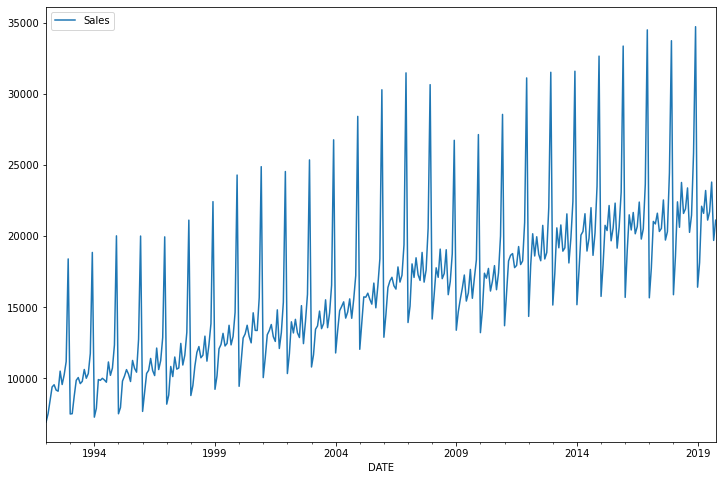

In [8]:
df.plot(figsize=(12,8))

In [14]:
# Where do we do the train test split ?
# We should be doing a split on atleast a year's cycle to capture the seasonalities
# Here we use 18 months or 1.5 years for the test set

In [11]:
len(df)

334

In [12]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [15]:
test_size = 18
test_ind = len(df) - test_size

In [16]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [17]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [18]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


### Scale the data

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()

In [21]:
scaler.fit(train)

MinMaxScaler()

In [23]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [24]:
scaled_train

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633],
       [0.02127505],
       [0.06636654],
       [0.10633895],
       [0.11345484],
       [0.09791606],
       [0.10368864],
       [0.13396747],
       [0.11163956],
       [0.12372931],
       [0.17506535],
       [0.43250799],
       [0.0124165 ],
       [0.03499855],
       [0.10829945],
       [0.10641156],
       [0.11149434],
       [0.10728289],
       [0.10154662],
       [0.1531731 ],
       [0.11904589],
       [0.13767064],
       [0.19663085],
       [0.47480395],
       [0.02105722],
       [0.03714058],
       [0.10445106],
       [0.11726692],
       [0.13367703],
       [0.12209556],
       [0.10332559],
       [0.1570578 ],
       [0.13694453],
       [0.12710572],
       [0.21104415],
       [0.474

In [25]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [26]:
len(test)

18

In [27]:
# Batch should be shotter than 18

In [28]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [32]:
X,y = generator[0]

In [33]:
X[0]

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266]])

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [35]:
n_features = 1

In [36]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Early Stopping and Validation Generator

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [41]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [42]:
model.fit_generator(generator, epochs=20, 
                    validation_data=validation_generator,
                   callbacks=[early_stop])

C:\Users\sayan\AppData\Local\Temp\ipykernel_24716\2268841108.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=20,


Epoch 1/20
304/304 [==============================] - 7s 14ms/step - loss: 0.0258 - val_loss: 0.0161
Epoch 2/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0178 - val_loss: 0.0249
Epoch 3/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0102 - val_loss: 0.0046
Epoch 4/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0072 - val_loss: 0.0049
Epoch 5/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 6/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 7/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 8/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0020 - val_loss: 0.0013


In [43]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

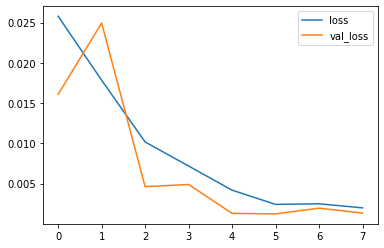

In [44]:
losses.plot()

### Evaluate on Test Data

In [45]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 47ms/step


#### Inverse the predictions for comparison

In [46]:
true_predictions = scaler.inverse_transform(test_predictions)

In [47]:
test['Predictions'] = true_predictions

C:\Users\sayan\AppData\Local\Temp\ipykernel_24716\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [48]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22099.406742
2018-06-01,21589,21066.960850
2018-07-01,21919,21281.191210
2018-08-01,23381,22984.154207
2018-09-01,20260,20686.857066
2018-10-01,21473,21231.598857
2018-11-01,25831,24963.497664
2018-12-01,34706,34134.498915
2019-01-01,16410,17401.101451


<AxesSubplot:xlabel='DATE'>

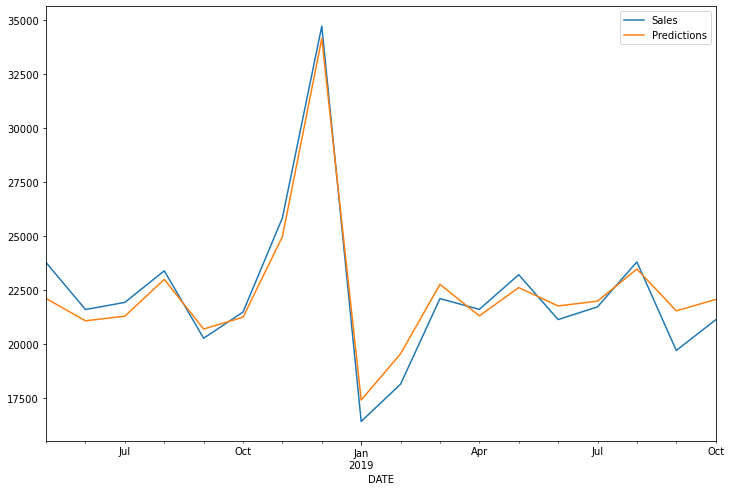

In [50]:
test.plot(figsize=(12,8))

#### Retrain and Forecasting

In [51]:
full_scalar = MinMaxScaler()
scaled_full_data = full_scalar.fit_transform(df)

In [52]:
lenght = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                               length=length, batch_size=1)

In [54]:
model = Sequential()
model.add(LSTM(100,activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs=7)

Epoch 1/7


C:\Users\sayan\AppData\Local\Temp\ipykernel_24716\4166999205.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=7)


322/322 [==============================] - 7s 12ms/step - loss: 0.0289
Epoch 2/7
322/322 [==============================] - 4s 12ms/step - loss: 0.0207
Epoch 3/7
322/322 [==============================] - 4s 12ms/step - loss: 0.0153
Epoch 4/7
322/322 [==============================] - 4s 12ms/step - loss: 0.0119
Epoch 5/7
322/322 [==============================] - 4s 12ms/step - loss: 0.0059
Epoch 6/7
322/322 [==============================] - 4s 12ms/step - loss: 0.0029
Epoch 7/7
322/322 [==============================] - 4s 12ms/step - loss: 0.0024


In [55]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 44ms/step


In [56]:
forecast = scaler.inverse_transform(forecast)

In [57]:
forecast

array([[23794.43187618],
       [33475.14735413],
       [16361.51558685],
       [17609.61113143],
       [20343.33640528],
       [20015.552742  ],
       [21232.22436428],
       [19723.88676524],
       [20173.40457416],
       [21735.15487862],
       [18786.76746488],
       [19833.65993881]])

In [58]:
# We need the timestamp to add into the graph

In [59]:
forecast_index=pd.date_range(start='2019-11-01', periods=periods,
                            freq="MS")

In [60]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [61]:
forecast_df=pd.DataFrame(data=forecast, index=forecast_index,
                        columns=['Forecast'])

<AxesSubplot:>

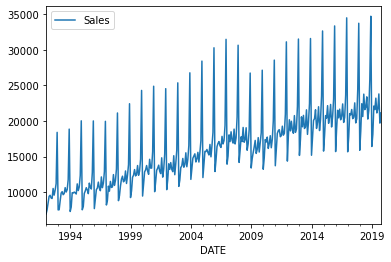

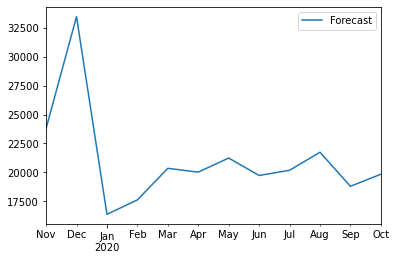

In [63]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

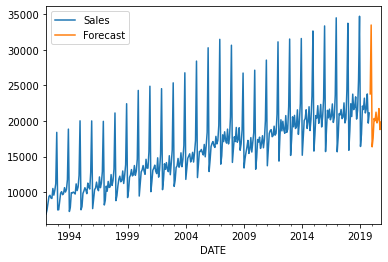

In [64]:
ax=df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

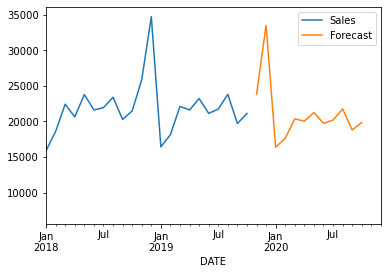

In [69]:
ax=df.plot()
forecast_df.plot(ax=ax)
plt.xlim("2018-01-01","2020-12-1")